# Validation of job titles in bios

In [1]:
# Standard library imports
import sys

# Third party imports
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
import prince
from networkx.algorithms import bipartite
from matplotlib.patches import Patch
import community as community_louvain
from netgraph import Graph


from nltk import ngrams
from collections import Counter

# Local application imports
sys.path.insert(0, '../Utility files')
import utils2
from utils2 import *


/tmp/ipykernel_1644283/976864978.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:

# load data
path = '/home/livtollanes/NewData/french/french1_updated.csv'

req_cols = ['follower_id', 'screen_name', 'description','description_cleantext','location', 'language', 'country']
dtypes = {'follower_id': 'object',
          'screen_name': 'object', 
          'description': 'object',
          'description_cleantext': 'object',
          'location': 'object',
          'language': 'object',
          'country': 'object'}


bios = pd.read_csv(path, usecols=req_cols, dtype=dtypes)

the data below comes from https://www.insee.fr/fr/information/6450559

In [3]:
#Load job title data
titles = pd.read_excel('/home/livtollanes/10.jan-thesis/labeldata/titles.xlsx')

In [5]:
# words1 = titles['title_female'].tolist()
# words2 = titles['title_man'].tolist()

# # Convert all items in the list to strings
# words1 = [str(item) for item in words1]
# words2 = [str(item) for item in words2]

# # Create a pattern for the words to be searched
# pattern1 = '|'.join(words1)
# pattern2 = '|'.join(words2)

# # Use str.contains to get rows where 'description_cleantext' contains any word from the lists
# filtered_df1 = bios[bios['description_cleantext'].str.contains(pattern1, na=False)]
# filtered_df2 = bios[bios['description_cleantext'].str.contains(pattern2, na=False)]

/tmp/ipykernel_1559056/841559411.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filtered_df1 = bios[bios['description_cleantext'].str.contains(pattern1, na=False)]
/tmp/ipykernel_1559056/841559411.py:14: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filtered_df2 = bios[bios['description_cleantext'].str.contains(pattern2, na=False)]


In [12]:
# def find_matching_word(description, words):
#     for word in words:
#         if contains_first_or_all_words(description, word):
#             return word
#     return None

# bios['job1'] = bios['description_cleantext'].apply(lambda x: find_matching_word(x, words1))
# bios['job2'] = bios['description_cleantext'].apply(lambda x: find_matching_word(x, words2))

# # Combine 'job1' and 'job2' into a single 'job' column
# bios['job'] = bios['job1'].combine_first(bios['job2'])

# # Drop the 'job1' and 'job2' columns
# bios.drop(['job1', 'job2'], axis=1, inplace=True)

In [18]:
# bios_with_job = bios[bios['job'].notnull()]
# bios_with_job[['job','description_cleantext']].iloc[30:50]

,job,description_cleantext
76,Régisseuse d'événementiel,Régisseuse d œuvres d art padawan féministe passionnée d arts
77,Journaliste,JournalisteRéd en chef RF magex lamanchelibreCollabore Figaro Magazine LeMeridionalOff et Asie Reportages
78,nan,membre titulaire de la commission éthique de nantesmetropole
80,Maire,Maire d AulnaySousBois Président de Paris terresdenvol Conseiller régional d iledefrance Secrétaire National lesrepublicains en charge de la Sécurité
85,nan,Pratique le culte du jus d ananas Instagram lolilas_
91,nan,Journaliste en formation à l EPJTours bretonnante Zellidja
92,Ébéniste,Sami Dubosc Ébéniste designer manufactureduboscetfils design art madeinfrance tih malvoyant handicap boosteurdebonheur les3b activateurdeprogrès
93,Social media manager,Bienvenue sur le compte Twitter des Socialistes de Montrouge social écologique solidaire jaimemontrouge montrougemaville
95,Journaliste,Journaliste reporter d images Ministère de l Éducation
101,Conseiller des activités physiques et sportives,Dircomcab externalisé ComPublique Compol Influence attractivité RP Conseiller Municipal Cassis Pdt think tank HELP Sec Nal E M Écologie Modernisme


In [8]:
# import re

# # Define a function that finds matching words in a string for words1
# def find_matching_words1(description):
#     matches = []
#     for word in words1:
#         # Split the word by commas and parentheses
#         parts = re.split(',|\(|\)', word)
#         # Check each part separately
#         for part in parts:
#             part = part.strip()  # Remove leading and trailing spaces
#             if part and part in description:
#                 matches.append(part)
#     return matches

# # Apply the function to the 'description_cleantext' column and assign the result to a new column 'job1'
# filtered_df1['job1'] = filtered_df1['description_cleantext'].apply(find_matching_words1)

# # Define a function that finds matching words in a string for words2
# def find_matching_words2(description):
#     matches = []
#     for word in words2:
#         # Split the word by commas and parentheses
#         parts = re.split(',|\(|\)', word)
#         # Check each part separately
#         for part in parts:
#             part = part.strip()  # Remove leading and trailing spaces
#             if part and part in description:
#                 matches.append(part)
#     return matches

# # Apply the function to the 'description_cleantext' column and assign the result to a new column 'job2'
# filtered_df2['job2'] = filtered_df2['description_cleantext'].apply(find_matching_words2)

/tmp/ipykernel_1515732/1780242890.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df1['job1'] = filtered_df1['description_cleantext'].apply(find_matching_words1)
/tmp/ipykernel_1515732/1780242890.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df2['job2'] = filtered_df2['description_cleantext'].apply(find_matching_words2)


In [20]:
# # Apply the function to the 'description_cleantext' column and assign the result to a new column 'job2'
# filtered_df1['job1'] = filtered_df2['description_cleantext'].apply(find_matching_words1)

/tmp/ipykernel_1515732/4228196134.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df1['job1'] = filtered_df2['description_cleantext'].apply(find_matching_words1)


In [4]:
import pandas as pd
#Create the data frame for the income data

data = {
    'Title': ['Marin-pêcheur', 'Marin-pêcheuse', 'Artisan', 'Artisane', 'Commerçant', 'Commerçante', 'Journaliste', 'Avocat', 'Avocate', 'Juriste', 'Pharmacien', 'Pharmacienne', 'Professeur d\'art', 'Professeure d\'arts', 'Chirurgien dentiste', 'Chirurgienne dentiste', 'Vétérinaire', 'Magistrat', 'Magistrate', 'Photographe', 'Infirmier', 'Infirmière', 'Sage-femme', 'Contrôleur des impôts', 'Opticien', 'Opticienne', 'Bibliothécaire', 'Puériculteur', 'Puéricultrice', 'Ambulancier', 'Ambulancière', 'Secrétaire', 'Caissier de magasin', 'Caissière de magasin', 'Concierge', 'Boulanger', 'Boulangère', 'Nettoyeur', 'Nettoyeuse', 'Jardinier', 'Jardinière', 'Ouvrier d\'art', 'Ouvrière d\'art', 'Docker', 'Diplomate', 'Ingénieur en chef', 'Médecin hospitalier'],
    'Income_monthly_av': [2400, 2400, 2300, 2300, 2600, 2600, 3500, 8000, 8000, 4100, 3600, 3600, 2900, 2900, 7000, 7000, 3300, 3600, 3600, 2100, 2600, 2600, 3100, 2600, 2600, 2600, 3100, 2800, 2800, 1800, 1800, 1900, 1600, 1600, 1800, 1800, 1800, 1500, 1500, 1600, 1600, 2200, 2200, 3700, 6500, 6500, 6000]
}

income = pd.DataFrame(data)

In [5]:
def find_job(description):
    words = description.lower().split()
    for title in income['Title']:
        if title.lower() in words:
            return title
    return None

bios['job'] = bios['description_cleantext'].apply(find_job)
jobs = bios.dropna(subset=['job'])

In [6]:
jobs = jobs.merge(income, left_on='job', right_on='Title', how='left')

In [7]:
from corg import DiscoverDimension, BenchmarkDimension

import graphfunk
from graphfunk import *
import ca_pipeline
from ca_pipeline import PipelineCorAnalysis

In [28]:
#Fit the CA on the full network 

# load data
path = '/home/livtollanes/NewData/french/french_edgelist_marker_threshold.csv'

req_cols = ['marker_id', 'follower_id', 'twitter_name','followers','french_followers', 'type', 'type2']
dtypes = {'marker_id': 'object',
          'follower_id': 'object',
          'twitter_name': 'object',
          'followers': 'int64',
          'french_followers': 'int64',
          'type': 'object',
          'type2': 'object'}


edgelist = pd.read_csv(path, usecols=req_cols, dtype=dtypes)


In [32]:
importlib.reload(ca_pipeline)

<module 'ca_pipeline' from '/home/livtollanes/10.jan-thesis/Code/Brand Validation/../Utility files/ca_pipeline.py'>

Starting graph checks...
Number of nodes: 115302
Edge number is sane - matches the number of rows in the inputted edgelist
Is the graph connected? True
Number of connected components: 1
Size of largest connected component: 115302
Number of communities: 3
Graph checks complete. Starting CA fitting pipeline...
Creating contingency table...
Performing CA analysis. Might take some time...
Plotting variance...


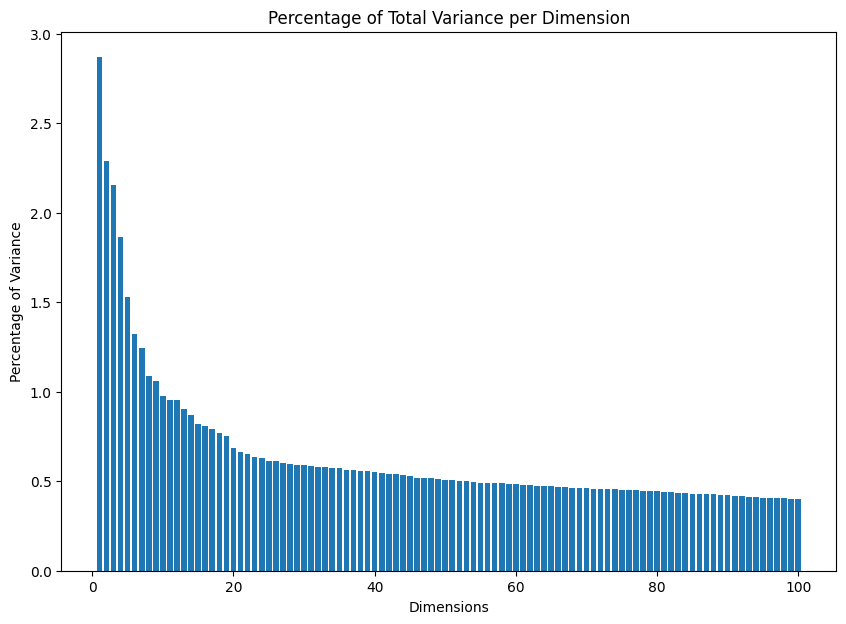

CA pipeline complete.


In [33]:

subset_name = 'full_network'
all = ca_pipeline.PipelineCorAnalysis(edgelist, subset_name)
path = '/home/livtollanes/NewData/coordinates/'
all.run_all(path)

In [8]:
#load coordinate files
coords = pd.read_csv('/home/livtollanes/NewData/coordinates/full_network_coords/full_network_row_coordinates.csv')

In [9]:
#change 'follower_id' to object 
coords['follower_id'] = coords['follower_id'].astype(str)


In [10]:
coords1 = coords[['follower_id', '0']]

In [11]:
coords_streamlined = utils2.streamline_IDs(source= jobs, df_tofilter= coords1, column= 'follower_id')

Number of unique follower_id in source DataFrame: 8459
Number of unique follower_id in filtered DataFrame after filtering: 8459
Removed 106620 rows from the DataFrame to be filtered.
8459 rows are left in the filtered DataFrame.


In [12]:
jobs1 = jobs.merge(coords_streamlined[['follower_id', '0']], on='follower_id', how='left')

In [59]:
jobs1.columns

Index(['follower_id', 'screen_name', 'description', 'location',
       'description_cleantext', 'language', 'country', 'job', 'Title',
       'Income_monthly_av', '0'],
      dtype='object')

In [17]:
# Get the jobs that have more than 50 counts
jobs_counts = jobs1['job'].value_counts()
jobs_over_50 = jobs_counts[jobs_counts > 50].index

# Create a subset of the DataFrame that only includes these jobs
jobs1_subset = jobs1[jobs1['job'].isin(jobs_over_50)]

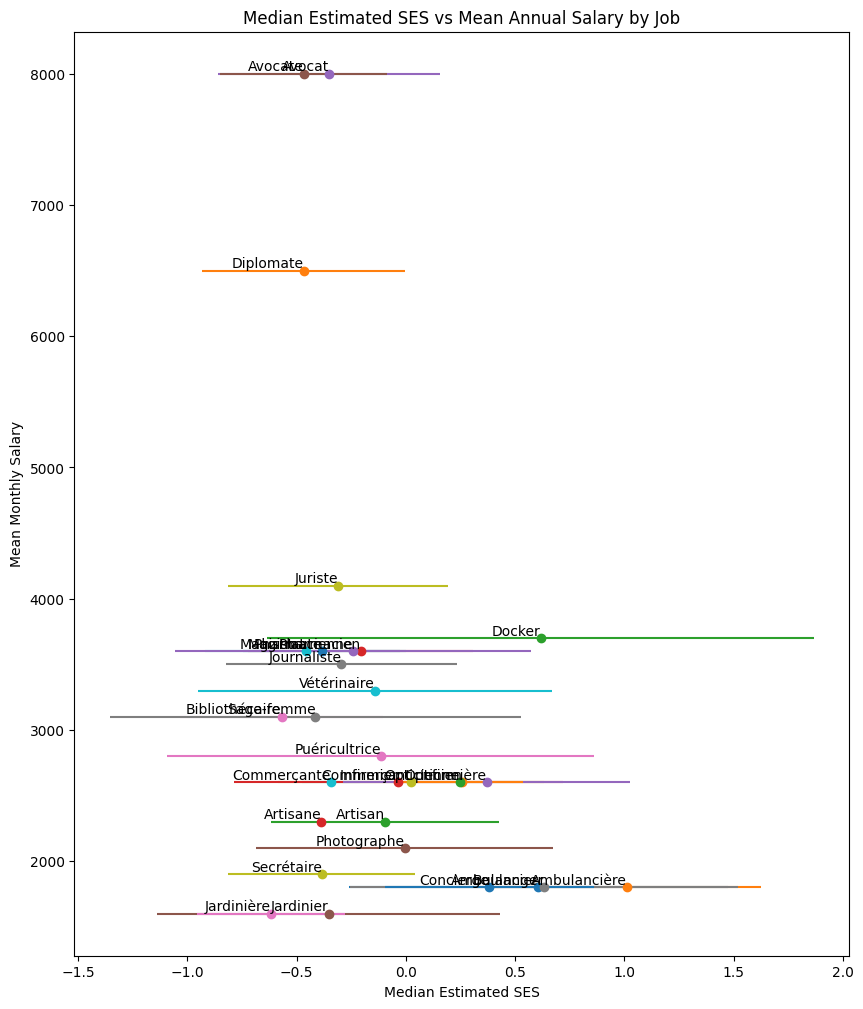

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the median of '0', its standard deviation, and mean of 'Income_monthly_av' for each job group
grouped = jobs1.groupby('job').agg({'0': ['median', 'std'], 'Income_monthly_av': 'mean'}).reset_index()

# Sort the jobs by median SES
grouped = grouped.sort_values(('0', 'median'))

plt.figure(figsize=(10, 12))  # Increase the height of the figure

# Plot error bars for each job with a small random jitter added to the y-coordinates
for i in range(grouped.shape[0]):
    jitter = np.random.uniform(-0.3, 0.3)  # adjust the range as needed
    plt.errorbar(x=grouped[('0', 'median')][i], 
                 y=grouped[('Income_monthly_av', 'mean')][i] + jitter, 
                 xerr=grouped[('0', 'std')][i], 
                 fmt='o')

# Add job labels to each point
for i in range(grouped.shape[0]):
    plt.text(grouped[('0', 'median')][i], 
             grouped[('Income_monthly_av', 'mean')][i], 
             grouped['job'][i], 
             ha = 'right', va = 'bottom')

plt.xlabel('Median Estimated SES')
plt.ylabel('Mean Monthly Salary')
plt.title('Median Estimated SES vs Mean Annual Salary by Job')
plt.show()

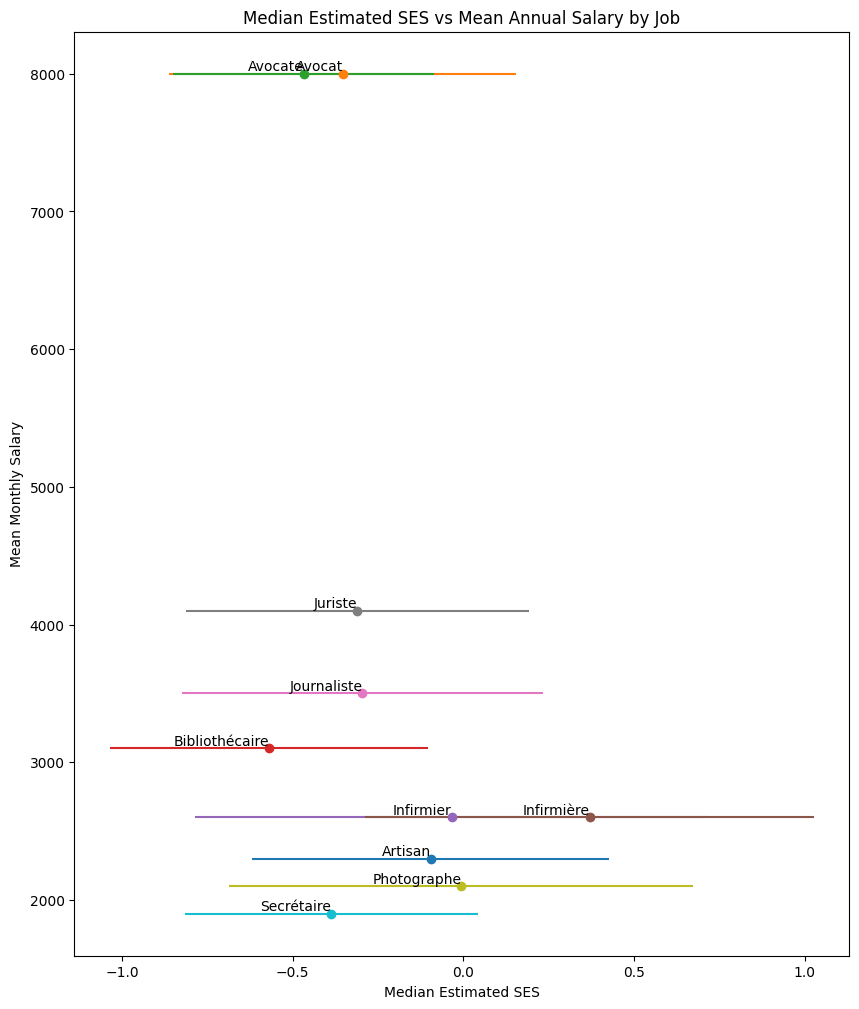

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the median of '0', its standard deviation, and mean of 'Income_monthly_av' for each job group
grouped_subset = jobs1_subset.groupby('job').agg({'0': ['median', 'std'], 'Income_monthly_av': 'mean'}).reset_index()

# Sort the jobs by median SES
grouped_subset = grouped_subset.sort_values(('0', 'median'))

plt.figure(figsize=(10, 12))  # Increase the height of the figure

# Plot error bars for each job with a small random jitter added to the y-coordinates
for i in range(grouped_subset.shape[0]):
    jitter = np.random.uniform(-0.3, 0.3)  # adjust the range as needed
    plt.errorbar(x=grouped_subset[('0', 'median')][i], 
                 y=grouped_subset[('Income_monthly_av', 'mean')][i] + jitter, 
                 xerr=grouped_subset[('0', 'std')][i], 
                 fmt='o')

# Add job labels to each point
for i in range(grouped_subset.shape[0]):
    plt.text(grouped_subset[('0', 'median')][i], 
             grouped_subset[('Income_monthly_av', 'mean')][i], 
             grouped_subset['job'][i], 
             ha = 'right', va = 'bottom')

plt.xlabel('Median Estimated SES')
plt.ylabel('Mean Monthly Salary')
plt.title('Median Estimated SES vs Mean Annual Salary by Job')
plt.show()